# DSxH 2324 Assignment 1: Prediction of Length Of Stay in ICU

## Introduction

We will work with the [**MIMIC-III Clinical Database Demo**](https://physionet.org/content/mimiciii-demo/1.4/) which contains all intensive care unit (ICU) stays for 100 patients (randomly selected from the subset of patients in the dataset who eventually die).
The main task is to predict the Length Of Stay (LOS) in the ICU using different strategies: (1) using the severity of illness score OASIS, and (2) using all the 
variables. 

#### OASIS

The Oxford Acute Severity of Illness Score (OASIS) is based on the following variables: age, elective surgery, prior length of stay (LOS) and seven physiologic measurements: Glasgow Coma Score (GCS), heart rate, mean arterial pressure (MAP), respiratory rate, temperature, urine output, ventilated. For each variable, the worst score across the first day in ICU should be used to tabulate OASIS.

See [here](https://alistairewj.github.io/project/oasis/) for more information.

**Observation**: The concept of *elective surgery* is where a patient is admitted to the intensive care unit either in routine preparation for a planned surgery or for stabilization after completion of a planned surgery. Elective surgery is an important covariate for many risk adjustments as patients who are admitted to the ICU for planned surgeries tend to be healthier than their counterparts.


## Exercise 1:

Predict if the length of stay (LOS) of the ICU patients are "short" or "long" (binary classification problem) based on the severity score OASIS of the fisrt 24 hours (and 48 hours) of an ICU stay.


### Instructions for the exercise 1

- We provide you the variables already computed and saved in csv files, except age, elective surgery, pre-LOS and temperature.

- In order to compute the age and pre-LOS and consult the elective surgery information you need to merge tables PATIENTS, ADMISSIONS and ICUSTAYS. 
    - You should compute the age at the time the patient is admitted to the ICU from *date of birth*, 'dob' from PATIENTS table, then you can drop dob from the dataframe. 
    - For the pre-LOS you should compare 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table. 
    - The elective surgery information is stored in the column 'admission_type' of PATIENTS, ADMISSIONS and ICUSTAYS table.

- You need CHARTEVENTS table to get the temperature (measures in Fahrenheit and Celsius) and D_ITEMS table to consult the itemid for the measure.
    - The variables can be duplicated, since they can come from Carevue or Metavision source systems of MIMIC-III, so you have to look for the different labels.
    - You can use pandas.DataFrame.loc to look for the itemid corresponding to labels of the temperature in D_ITEMS table. If you do not know the exact label you are looking for, you can look for the strings in column label containing 'Temperature' using pandas.Series.str.contains as follows:
    > df_ditems.loc[df_ditems.label.str.contains('Temperature', case=False, na=False, regex=False)]


- Once you have computed these variables you can read the rest of variables, provided in the csv files, and merge them into a single dataframe to pass it to the OASIS function (see [here](https://gist.github.com/tompollard/d4c216d0c4ad30481c99)) and compute the severity score.


- The Glasgow Coma Scale is stored in a different way in Metavision and Carevue. 
    - Metavision saves the three tests separately: GCS - Eye Opening,  GCS - Motor Response, GCS - Verbal Response
    - Carevue saves a single test: GCS_total.
    - We provide you 4 separate csv files with these information: GCS_E_metavision.csv, GCS_M_metavision.csv, GCS_V_metavision.csv and  GCS_total_carevue.csv
    - You should concatenate the values and keep the worst one which corresponds to the minimum score.


- Each csv file contains a dataframe with: [subject_id, hadm_id, icustay_id, variable_Time and variable value], except for the ventilation which just contains:  [subject_id, hadm_id, icustay_id, variable_Time], since the important information is if there is ventilation or not (YES or NO) and when has been installed. 


- Normalize the measures time. Use intime, which provides the date and time the patient was transferred into the ICU, as the reference value to compute the time that has passed since then until the variable measurement were taken.

- After the normalization, you can filter the instances to keep the ones of the first 24 hours (or 48 hours) as observations to compute the OASIS score. 
    - Try to different strategies:
        - All the instances of the first 24 hours.
        - All the instances of the first 48 hours.

- For the prediction, consider the following binary label:
    - LOS < 4: short stay
    - Otherwise: long stay.
    
- Use Random forest to classify using a 5-fold cross validation.

- As can be seen in the code to compute OASIS, the score is NaN if any of the considered variables has all its instances as NaN. MIMIC-III has many NaN values and the demo subset is more limited in the number. So, the number of samples with OASIS different of NaNs considering first 24h is just 8. You can use the first 48h but the number is also very limited and the performance of the proposed classifier will be very poor. 

- We suggest that you also try an alternative to compute the OASIS score. 
    - You can change the original code to consider the variable as 0.0 (state in normal range) when all instances of the variable are NaN. For that use np.nansum instead of using sum in the line:
        > oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp,oasis_temp, oasis_urine, oasis_vent, oasis_surg]). 
   
- Show the number of NaN values of OASIS for the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h).
    
- Analyze the results of the three different alternatives (Original OASIS with 48h, Modification of OASIS with 24h and 48h):
    - Compare the mean accuracy
    - Build the confusion matrix



In [1]:
# Your solution here:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Download the MIMIC-III Clinical Database Demo can be download from [here](https://physionet.org/content/mimiciii-demo/1.4/) and copy the csv files in a 'data' folder.


In [375]:
path = "data/" #path to my data folder 

In [376]:
df_1 = pd.read_csv(path+"PATIENTS.csv")
df_2 = pd.read_csv(path+"ADMISSIONS.csv")
df_3 = pd.read_csv(path+"ICUSTAYS.csv")
df_merged = df_2.merge(df_3, on=["subject_id", "hadm_id"])
df_merged = df_1.merge(df_merged, on="subject_id")
df_1 = None
df_2 = None
df_3 = None
df_merged.columns


Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'row_id_x', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'row_id_y',
       'icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los'],
      dtype='object')

In [377]:
df_merged.loc[:,("dob", "admittime")]

,dob,admittime
0,2094-03-05 00:00:00,2164-10-23 21:09:00
1,2090-06-05 00:00:00,2126-08-14 22:32:00
2,2038-09-03 00:00:00,2125-10-04 23:36:00
3,2075-09-21 00:00:00,2149-05-26 17:19:00
4,2114-06-20 00:00:00,2163-05-14 20:43:00
...,...,...
131,2057-11-15 00:00:00,2112-05-28 15:45:00
132,1878-05-14 00:00:00,2178-05-14 20:29:00
133,2078-06-16 00:00:00,2123-11-24 14:14:00
134,2107-06-27 00:00:00,2180-07-19 06:55:00


In [378]:
from datetime import datetime
def get_age(data):
    dob = datetime.strptime(data["dob"], r"%Y-%m-%d %H:%M:%S")
    admittime = datetime.strptime(data["admittime"], r"%Y-%m-%d %H:%M:%S")
    return (admittime-dob).days // 365
    

df_merged["age"] = df_merged.apply(get_age, axis=1)
df_merged.drop('dob', axis=1, inplace=True)
df_merged

,row_id,subject_id,gender,dod,dod_hosp,dod_ssn,expire_flag,row_id_x,hadm_id,admittime,...,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,age
0,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70
1,9472,10011,F,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,12263,105331,2126-08-14 22:32:00,...,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507,36
2,9474,10013,F,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,12265,165520,2125-10-04 23:36:00,...,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499,87
3,9478,10017,F,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1,12269,199207,2149-05-26 17:19:00,...,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436,73
4,9479,10019,M,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1,12270,177759,2163-05-14 20:43:00,...,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,31838,44083,M,2114-02-20 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,1,41055,198330,2112-05-28 15:45:00,...,286428,metavision,CCU,CCU,7,7,2112-05-29 02:01:33,2112-06-01 16:50:40,3.6174,54
132,31853,44154,M,2178-05-15 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,1,41070,174245,2178-05-14 20:29:00,...,217724,metavision,MICU,MICU,50,50,2178-05-14 20:29:55,2178-05-15 11:31:12,0.6259,300
133,31867,44212,F,2124-01-29 00:00:00,NaN,2124-01-29 00:00:00,1,41087,163189,2123-11-24 14:14:00,...,239396,metavision,MICU,MICU,50,50,2123-11-24 14:14:29,2123-12-25 17:12:19,31.1235,45
134,31870,44222,M,2182-08-03 00:00:00,2182-08-03 00:00:00,NaN,1,41090,192189,2180-07-19 06:55:00,...,238186,metavision,CCU,CCU,7,7,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,73


In [379]:
from datetime import datetime
def get_pre_los(data):
    intime = datetime.strptime(data["intime"], r"%Y-%m-%d %H:%M:%S")
    admittime = datetime.strptime(data["admittime"], r"%Y-%m-%d %H:%M:%S")
    return (intime-admittime).total_seconds() / (3600*24)
    

df_merged["prelos"] = df_merged.apply(get_pre_los, axis=1)
df_merged

,row_id,subject_id,gender,dod,dod_hosp,dod_ssn,expire_flag,row_id_x,hadm_id,admittime,...,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los,age,prelos
0,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,0.000868
1,9472,10011,F,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1,12263,105331,2126-08-14 22:32:00,...,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507,36,0.001389
2,9474,10013,F,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1,12265,165520,2125-10-04 23:36:00,...,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499,87,0.001389
3,9478,10017,F,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1,12269,199207,2149-05-26 17:19:00,...,carevue,CCU,CCU,7,7,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436,73,3.064919
4,9479,10019,M,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1,12270,177759,2163-05-14 20:43:00,...,carevue,MICU,MICU,15,15,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938,48,0.000648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,31838,44083,M,2114-02-20 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,1,41055,198330,2112-05-28 15:45:00,...,metavision,CCU,CCU,7,7,2112-05-29 02:01:33,2112-06-01 16:50:40,3.6174,54,0.428160
132,31853,44154,M,2178-05-15 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,1,41070,174245,2178-05-14 20:29:00,...,metavision,MICU,MICU,50,50,2178-05-14 20:29:55,2178-05-15 11:31:12,0.6259,300,0.000637
133,31867,44212,F,2124-01-29 00:00:00,NaN,2124-01-29 00:00:00,1,41087,163189,2123-11-24 14:14:00,...,metavision,MICU,MICU,50,50,2123-11-24 14:14:29,2123-12-25 17:12:19,31.1235,45,0.000336
134,31870,44222,M,2182-08-03 00:00:00,2182-08-03 00:00:00,NaN,1,41090,192189,2180-07-19 06:55:00,...,metavision,CCU,CCU,7,7,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,73,0.001134


In [380]:
df_merged_reduced = df_merged[["subject_id", "hadm_id", "admittime", "dischtime", "admission_type", "icustay_id","intime","outtime","los","age", "prelos"]]
df_merged_reduced


,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,prelos
0,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,0.000868
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,232110,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507,36,0.001389
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499,87,0.001389
3,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,EMERGENCY,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436,73,3.064919
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938,48,0.000648
...,...,...,...,...,...,...,...,...,...,...,...
131,44083,198330,2112-05-28 15:45:00,2112-06-07 16:50:00,EMERGENCY,286428,2112-05-29 02:01:33,2112-06-01 16:50:40,3.6174,54,0.428160
132,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,217724,2178-05-14 20:29:55,2178-05-15 11:31:12,0.6259,300,0.000637
133,44212,163189,2123-11-24 14:14:00,2123-12-30 14:31:00,EMERGENCY,239396,2123-11-24 14:14:29,2123-12-25 17:12:19,31.1235,45,0.000336
134,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,EMERGENCY,238186,2180-07-19 06:56:38,2180-07-20 14:48:45,1.3279,73,0.001134


In [381]:
df_chartevents = pd.read_csv(path+"CHARTEVENTS.csv")
df_d_items = pd.read_csv(path+"D_ITEMS.csv")
print(df_chartevents.columns)
print(df_d_items.columns)

C:\Users\manue\AppData\Local\Temp\ipykernel_24064\743348770.py:1: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_chartevents = pd.read_csv(path+"CHARTEVENTS.csv")


Index(['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'itemid', 'charttime',
       'storetime', 'cgid', 'value', 'valuenum', 'valueuom', 'warning',
       'error', 'resultstatus', 'stopped'],
      dtype='object')
Index(['row_id', 'itemid', 'label', 'abbreviation', 'dbsource', 'linksto',
       'category', 'unitname', 'param_type', 'conceptid'],
      dtype='object')


In [382]:
# 676, 677 223762 Temperature
df_merged_temp = df_chartevents.merge(df_d_items[df_d_items.itemid.isin([676,677,223762])], on="itemid")
df_merged_3 = df_merged.merge(df_merged_temp, on=["subject_id", "hadm_id"])
df_merged_3

,row_id,subject_id,gender,dod,dod_hosp,dod_ssn,expire_flag,row_id_x_x,hadm_id,admittime,...,stopped,row_id_y_y,label,abbreviation,dbsource_y,linksto,category,unitname,param_type,conceptid
0,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,NotStopd,628,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,NotStopd,628,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,NotStopd,628,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,NotStopd,628,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,9467,10006,F,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1,12258,142345,2164-10-23 21:09:00,...,NotStopd,628,Temperature C (calc),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2962,30876,40310,M,2144-12-31 00:00:00,2144-12-31 00:00:00,NaN,1,39869,186361,2144-07-11 15:02:00,...,NaN,12758,Temperature Celsius,Temperature C,metavision,chartevents,Routine Vital Signs,?C,Numeric,NaN
2963,30876,40310,M,2144-12-31 00:00:00,2144-12-31 00:00:00,NaN,1,39869,186361,2144-07-11 15:02:00,...,NaN,12758,Temperature Celsius,Temperature C,metavision,chartevents,Routine Vital Signs,?C,Numeric,NaN
2964,30876,40310,M,2144-12-31 00:00:00,2144-12-31 00:00:00,NaN,1,39869,186361,2144-07-11 15:02:00,...,NaN,12758,Temperature Celsius,Temperature C,metavision,chartevents,Routine Vital Signs,?C,Numeric,NaN
2965,30876,40310,M,2144-12-31 00:00:00,2144-12-31 00:00:00,NaN,1,39869,186361,2144-07-11 15:02:00,...,NaN,12758,Temperature Celsius,Temperature C,metavision,chartevents,Routine Vital Signs,?C,Numeric,NaN


In [384]:
df_merged_temp = df_merged_temp[["subject_id", "hadm_id", "icustay_id", "charttime", "storetime","value"]]
df_merged_temp["value"] = df_merged_temp["value"].astype(float)
df_merged_temp

,subject_id,hadm_id,icustay_id,charttime,storetime,value
0,40310,186361,210989.0,2144-07-13 21:00:00,2144-07-13 23:12:00,39.100000
1,40310,186361,210989.0,2144-07-13 22:00:00,2144-07-13 23:13:00,38.900000
2,40310,186361,210989.0,2144-07-13 23:00:00,2144-07-13 23:12:00,38.600000
3,40310,186361,210989.0,2144-07-14 00:00:00,2144-07-14 00:27:00,38.000000
4,40310,186361,210989.0,2144-07-14 01:00:00,2144-07-14 01:02:00,37.200000
...,...,...,...,...,...,...
2704,10126,160445,249805.0,2171-08-14 10:00:00,2171-08-14 09:55:00,36.599998
2705,10126,160445,249805.0,2171-08-14 11:00:00,2171-08-14 10:59:00,36.200001
2706,10126,160445,249805.0,2171-08-14 12:00:00,2171-08-14 12:04:00,36.099998
2707,10126,160445,249805.0,2171-08-14 12:30:00,2171-08-14 12:31:00,36.000000


In [385]:
df_GCS_E = pd.read_csv("variables/GCS_E_metavision.csv")
df_GCS_E.rename(columns={"GCS_E_Time":"GCS_time"}, inplace=True)
df_GCS_M = pd.read_csv("variables/GCS_M_metavision.csv")
df_GCS_M.rename(columns={"GCS_M_Time":"GCS_time"}, inplace=True)
df_GCS_V = pd.read_csv("variables/GCS_V_metavision.csv")
df_GCS_V.rename(columns={"GCS_V_Time":"GCS_time"}, inplace=True)
df_GCS_T = pd.read_csv("variables/GCS_total_carevue.csv")
df_GCS_T.rename(columns={"GCS_total_Carevue_Time":"GCS_time"}, inplace=True)

df_GCS = df_GCS_E.merge(df_GCS_M, how="outer").merge(df_GCS_V, how="outer").merge(df_GCS_T, how="outer")

df_GCS_E = None
df_GCS_M = None
df_GCS_V = None
df_GCS_T = None

df_GCS["GCS"] = df_GCS.apply(lambda x: np.nanmin([x["GCS_E"],x["GCS_M"],x["GCS_V"],x["GCS_total_Carevue"]]), axis=1)
df_GCS.drop(["GCS_E","GCS_M","GCS_V","GCS_total_Carevue", "Unnamed: 0"], axis=1, inplace=True)
df_GCS

C:\Users\manue\AppData\Local\Temp\ipykernel_24064\2313237130.py:17: RuntimeWarning: All-NaN axis encountered
  df_GCS["GCS"] = df_GCS.apply(lambda x: np.nanmin([x["GCS_E"],x["GCS_M"],x["GCS_V"],x["GCS_total_Carevue"]]), axis=1)


,subject_id,hadm_id,icustay_id,GCS_time,GCS
0,40124,126179,279554.0,2130-02-04 04:00:00,1.0
1,40124,126179,279554.0,2130-02-04 08:00:00,1.0
2,40124,126179,279554.0,2130-02-04 12:00:00,4.0
3,40124,126179,279554.0,2130-02-04 16:00:00,4.0
4,40124,126179,279554.0,2130-02-04 20:13:00,4.0
...,...,...,...,...,...
7396,10130,156668,241562.0,2161-02-06 05:00:00,15.0
7397,10130,156668,241562.0,2161-02-06 08:00:00,15.0
7398,10130,156668,241562.0,2161-02-06 10:00:00,15.0
7399,10132,197611,292910.0,2123-08-24 03:00:00,15.0


In [386]:
df_heart = pd.read_csv("variables/heartRate.csv")
df_heart.drop(["Unnamed: 0"], axis=1, inplace=True)
df_MAP = pd.read_csv("variables/MAP.csv")
df_MAP.drop(["Unnamed: 0"], axis=1, inplace=True)
df_respiratory = pd.read_csv("variables/RespiratoryRate.csv")
df_respiratory.drop(["Unnamed: 0"], axis=1, inplace=True)
df_urine = pd.read_csv("variables/urine.csv")
df_urine.drop(["Unnamed: 0"], axis=1, inplace=True)
df_ventilation = pd.read_csv("variables/ventilation.csv")
df_ventilation.rename(columns={"starttime":"vent_Time"}, inplace=True)
df_ventilation.drop(["Unnamed: 0"], axis=1, inplace=True)

df_test = pd.concat([df_heart, df_MAP, df_respiratory, df_urine,df_ventilation,df_merged_temp,df_GCS])
df_test

,subject_id,hadm_id,icustay_id,hrate_Time,hrate,MAP_Time,MAP,resp_rate_Time,resp_rate,urine_Time,urine,vent_Time,charttime,storetime,value,GCS_time,GCS
0,10006,142345,206504.0,2164-10-23 22:40:00,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10006,142345,206504.0,2164-10-23 23:00:00,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,142345,206504.0,2164-10-24 00:00:00,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10006,142345,206504.0,2164-10-24 01:00:00,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10006,142345,206504.0,2164-10-24 02:00:00,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7396,10130,156668,241562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2161-02-06 05:00:00,15.0
7397,10130,156668,241562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2161-02-06 08:00:00,15.0
7398,10130,156668,241562.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2161-02-06 10:00:00,15.0
7399,10132,197611,292910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2123-08-24 03:00:00,15.0


In [387]:
df_final_reduced = df_merged_reduced.merge(df_test, on=["subject_id", "hadm_id","icustay_id"])
df_final_reduced

,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,...,resp_rate_Time,resp_rate,urine_Time,urine,vent_Time,charttime,storetime,value,GCS_time,GCS
0,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,EMERGENCY,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67809,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,217992,2170-12-15 04:41:39,2170-12-19 19:33:09,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2170-12-19 00:04:00,5.0
67810,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,217992,2170-12-15 04:41:39,2170-12-19 19:33:09,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2170-12-19 04:16:00,5.0
67811,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,217992,2170-12-15 04:41:39,2170-12-19 19:33:09,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2170-12-19 08:00:00,5.0
67812,44228,103379,2170-12-15 03:14:00,2170-12-24 18:00:00,EMERGENCY,217992,2170-12-15 04:41:39,2170-12-19 19:33:09,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2170-12-19 12:00:00,5.0


In [388]:
def norm_time(data, label):
    if not pd.isna(data[label]):
        intime = datetime.strptime(data["intime"], r"%Y-%m-%d %H:%M:%S")
        other = datetime.strptime(data[label], r"%Y-%m-%d %H:%M:%S")
        return (other-intime).total_seconds() / (3600*24)

for l in ['dischtime', 'outtime', 'hrate_Time', 'MAP_Time', 'resp_rate_Time', 'urine_Time', 'vent_Time', 'charttime', 'storetime', 'GCS_time']:
    df_final_reduced[l] = df_final_reduced.apply(lambda x: norm_time(x, l), axis=1)
#df_final_reduced.groupby(by=["subject_id","hadm_id","icustay_id"]).apply(apply_oasis)
    

In [389]:
df_final_reduced["admission_type"] = df_final_reduced["admission_type"].str.lower()
df_final_reduced

,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,...,resp_rate_Time,resp_rate,urine_Time,urine,vent_Time,charttime,storetime,value,GCS_time,GCS
0,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67809,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807187,5.0
67810,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.982188,5.0
67811,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.137743,5.0
67812,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.304410,5.0


In [390]:

df_final_reduced.loc[np.logical_not(pd.isna(df_final_reduced["vent_Time"])), "vent"] = "y"
df_final_reduced.loc[pd.isna(df_final_reduced["vent_Time"]), "vent"] = "n"
df_final_reduced

,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,...,resp_rate,urine_Time,urine,vent_Time,charttime,storetime,value,GCS_time,GCS,vent
0,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n
1,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n
2,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n
3,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n
4,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67809,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.807187,5.0,n
67810,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.982188,5.0,n
67811,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.137743,5.0,n
67812,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.304410,5.0,n


In [391]:
# short stay 1, long stay 0
df_final_reduced["los_oh"] = (df_final_reduced["los"] < 4.0).astype(int)
df_final_reduced

,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,...,urine_Time,urine,vent_Time,charttime,storetime,value,GCS_time,GCS,vent,los_oh
0,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
1,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
2,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
3,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
4,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67809,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,3.807187,5.0,n,0
67810,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,3.982188,5.0,n,0
67811,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,4.137743,5.0,n,0
67812,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,4.304410,5.0,n,0


In [405]:
df_final_reduced.rename(columns={"GCS":"GCS_total","value":"temp_c", "vent":"ventilated"}, inplace=True)

In [406]:
time_labels = ['hrate_Time', 'MAP_Time', 'resp_rate_Time', 'urine_Time', 'vent_Time', 'charttime', 'storetime']
df_final_24 = df_final_reduced[
                            (df_final_reduced['hrate_Time']< 1.0) |
                            (df_final_reduced['MAP_Time']< 1.0) |
                            (df_final_reduced['resp_rate_Time']< 1.0) |
                            (df_final_reduced['urine_Time']< 1.0) |
                            (df_final_reduced['vent_Time']< 1.0) |
                            (df_final_reduced['charttime']< 1.0) |
                            (df_final_reduced['storetime']< 1.0) |
                            (df_final_reduced['GCS_time']< 1.0)
                               ]

df_final_24

,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,...,urine_Time,urine,vent_Time,charttime,storetime,temp_c,GCS_time,GCS_total,ventilated,los_oh
0,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
1,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
2,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
3,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
4,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67785,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,0.667604,5.0,n,0
67786,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,0.749549,5.0,n,0
67787,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,0.816910,5.0,n,0
67788,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,0.900243,5.0,n,0


In [407]:
time_labels = ['hrate_Time', 'MAP_Time', 'resp_rate_Time', 'urine_Time', 'vent_Time', 'charttime', 'storetime']
df_final_48 = df_final_reduced[
                            (df_final_reduced['hrate_Time'] < 2.0) |
                            (df_final_reduced['MAP_Time'] < 2.0) |
                            (df_final_reduced['resp_rate_Time'] < 2.0) |
                            (df_final_reduced['urine_Time'] < 2.0) |
                            (df_final_reduced['vent_Time'] < 2.0) |
                            (df_final_reduced['charttime'] < 2.0) |
                            (df_final_reduced['storetime'] < 2.0) |
                            (df_final_reduced['GCS_time']< 2.0)
                               ]

df_final_48

,subject_id,hadm_id,admittime,dischtime,admission_type,icustay_id,intime,outtime,los,age,...,urine_Time,urine,vent_Time,charttime,storetime,temp_c,GCS_time,GCS_total,ventilated,los_oh
0,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
1,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
2,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
3,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
4,10006,142345,2164-10-23 21:09:00,8.836632,emergency,206504,2164-10-23 21:10:15,1.632546,1.6325,70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67793,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,1.471076,5.0,n,0
67794,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,1.666910,5.0,n,0
67795,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,1.748854,5.0,n,0
67796,44228,103379,2170-12-15 03:14:00,9.554410,emergency,217992,2170-12-15 04:41:39,4.619097,4.6191,58,...,NaN,NaN,NaN,NaN,NaN,NaN,1.840521,5.0,n,0


In [394]:
def compute_oasis(pd_dataframe):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan 
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan     
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan 
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan 
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan 
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan 
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan 
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan 
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan 
    # Return sum
    oasis_score = sum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    return oasis_score

In [454]:

def process_group(data):
    return compute_oasis(data[["prelos","age","GCS_total","hrate","MAP","resp_rate","temp_c","urine","ventilated","admission_type"]]), np.amax(data["los_oh"])

data_48_original = df_final_48.groupby(by=["subject_id","hadm_id","icustay_id"]).apply(process_group)

In [412]:
def compute_oasis_2(pd_dataframe):
    """
    Takes Pandas DataFrame as an argument and computes Oxford Acute 
    Severity of Illness Score (OASIS) (http://oasisicu.com/)
    
    The DataFrame should include only measurements taken over the first 24h 
    from admission. pd_dataframe should contain the following columns:
    
    'prelos' => Pre-ICU length of stay, hours
    'age' => Age of patient, years
    'GCS_total' => Total Glasgow Coma Scale for patient
    'hrate' => All heart rate measurements
    'MAP' => All mean arterial blood pressure measurements
    'resp_rate' => All respiratory rate measurements
    'temp_c' => All temperature measurements, C
    'urine' => Total urine output over 24 h (note, not consecutive measurements)
    'ventilated' => Is patient ventilated? (y,n)
    'admission_type' => Type of admission (elective, urgent, emergency) 
    
    Reference:
    Johnson AE, Kramer AA, Clifford GD. A new severity of illness scale 
    using a subset of Acute Physiology And Chronic Health Evaluation 
    data elements shows comparable predictive accuracy.
    Crit Care Med. 2013 Jul;41(7):1711-8. doi: 10.1097/CCM.0b013e31828a24fe
    http://www.ncbi.nlm.nih.gov/pubmed/23660729
    """
    
    # 10 variables
    oasis_score, oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg = 0,0,0,0,0,0,0,0,0,0,0   
    # Pre-ICU length of stay, hours
    for val in pd_dataframe['prelos']:
        if val >= 4.95 and val <= 24.0:
            oasis_prelos = np.nanmax([0,oasis_prelos])
        elif val > 311.8:
            oasis_prelos = np.nanmax([1,oasis_prelos])
        elif val > 24.0 and val <= 311.8:
            oasis_prelos = np.nanmax([2,oasis_prelos])
        elif val >= 0.17 and val < 4.95:
            oasis_prelos = np.nanmax([3,oasis_prelos])
        elif val < 0.17:
            oasis_prelos = np.nanmax([5,oasis_prelos])
        else:
            oasis_prelos = np.nanmax([np.nan,oasis_prelos])  
    if pd_dataframe['prelos'].isnull().all():
        oasis_prelos = np.nan 
    # Age, years
    for val in pd_dataframe['age']:
        if val < 24:
            oasis_age = np.nanmax([0,oasis_age])
        elif val >= 24 and val <= 53:
            oasis_age = np.nanmax([3,oasis_age])
        elif val > 53 and val <= 77:
            oasis_age = np.nanmax([6,oasis_age])
        elif val > 77 and val <= 89:
            oasis_age = np.nanmax([9,oasis_age])
        elif val > 89:
            oasis_age = np.nanmax([7,oasis_age])
        else:
            oasis_age = np.nanmax([np.nan,oasis_age])
    if pd_dataframe['age'].isnull().all():
        oasis_age = np.nan 
    # Glasgow Coma Scale
    for val in pd_dataframe['GCS_total']:
        if val == 15:
            oasis_gcs = np.nanmax([0,oasis_gcs])
        elif val == 14:
            oasis_gcs = np.nanmax([3,oasis_gcs])
        elif val >= 8 and val <= 13:
            oasis_gcs = np.nanmax([4,oasis_gcs])
        elif val >= 3 and val <= 7:
            oasis_gcs = np.nanmax([10,oasis_gcs])
        else:
            oasis_gcs = np.nanmax([np.nan,oasis_gcs])
    if pd_dataframe['GCS_total'].isnull().all():
        oasis_gcs = np.nan     
    # Heart rate
    for val in pd_dataframe['hrate']:
        if val >= 33 and val <= 88:
            oasis_hr = np.nanmax([0,oasis_hr])
        elif val > 88 and val <= 106:
            oasis_hr = np.nanmax([1,oasis_hr])
        elif val > 106 and val <= 125:
            oasis_hr = np.nanmax([3,oasis_hr])
        elif val < 33:
            oasis_hr = np.nanmax([4,oasis_hr])
        elif val > 125:
            oasis_hr = np.nanmax([6,oasis_hr])
        else:
            oasis_hr = np.nanmax([np.nan,oasis_hr])
    if pd_dataframe['hrate'].isnull().all():
        oasis_hr = np.nan 
    # Mean arterial pressure
    for val in pd_dataframe['MAP']:
        if val >=61.33 and val <= 143.44:
            oasis_map = np.nanmax([0,oasis_map])
        elif val >= 51.0 and val < 61.33:
            oasis_map = np.nanmax([2,oasis_map])
        elif (val >= 20.65 and val < 51.0) or (val > 143.44):
            oasis_map = np.nanmax([3,oasis_map])
        elif val < 20.65:
            oasis_map = np.nanmax([4,oasis_map])
        else:
            oasis_map = np.nanmax([np.nan,oasis_map])
    if pd_dataframe['MAP'].isnull().all():
        oasis_map = np.nan 
    # Respiratory Rate
    for val in pd_dataframe['resp_rate']:
        if val >=13 and val <= 22:
            oasis_resp = np.nanmax([0,oasis_resp])
        elif (val >= 6 and val <= 12) or (val >= 23 and val <= 30):
            oasis_resp = np.nanmax([1,oasis_resp])
        elif val > 30 and val <= 44:
            oasis_resp = np.nanmax([6,oasis_resp])
        elif val > 44:
            oasis_resp = np.nanmax([9,oasis_resp])
        elif val < 6:
            oasis_resp = np.nanmax([10,oasis_resp])
        else:
            oasis_resp = np.nanmax([np.nan,oasis_resp])
    if pd_dataframe['resp_rate'].isnull().all():
        oasis_resp = np.nan 
    # Temperature, C
    for val in pd_dataframe['temp_c']:
        if val >= 36.40 and val <= 36.88:
            oasis_temp = np.nanmax([0,oasis_temp])
        elif (val >= 35.94 and val < 36.40) or (val > 36.88 and val <= 39.88):
            oasis_temp = np.nanmax([2,oasis_temp])
        elif val < 33.22:
            oasis_temp = np.nanmax([3,oasis_temp])            
        elif val >= 33.22 and val < 35.94:
            oasis_temp = np.nanmax([4,oasis_temp])
        elif val > 39.88:
            oasis_temp = np.nanmax([6,oasis_temp])
        else:
            oasis_temp = np.nanmax([np.nan,oasis_temp])
    if pd_dataframe['temp_c'].isnull().all():
        oasis_temp = np.nan 
    # Urine output, cc/day (total over 24h)
    val = np.max(pd_dataframe['urine'])
    if val >=2544.0 and val <= 6896.0:
        oasis_urine = np.nanmax([0,oasis_urine])
    elif val >= 1427.0 and val < 2544.0:
        oasis_urine = np.nanmax([1,oasis_urine])
    elif val >= 671.0 and val < 1427.0:
        oasis_urine = np.nanmax([5,oasis_urine])
    elif val > 6896.0:
        oasis_urine = np.nanmax([8,oasis_urine])
    elif val < 671:
        oasis_urine = np.nanmax([10,oasis_urine])
    else:
        oasis_urine = np.nanmax([np.nan,oasis_urine])
    if pd_dataframe['urine'].isnull().all():
        oasis_urine = np.nan 
    # Ventilated y/n
    for val in pd_dataframe['ventilated']:
        if val == 'n':
            oasis_vent = np.nanmax([0,oasis_vent])
        elif val == 'y':
            oasis_vent = np.nanmax([9,oasis_vent])
        else:
            oasis_vent = np.nanmax([np.nan,oasis_vent])
    if pd_dataframe['ventilated'].isnull().all():
        oasis_vent = np.nan 
    # Elective surgery y/n
    for val in pd_dataframe['admission_type']:
        if val == 'elective':
            oasis_surg = np.nanmax([0,oasis_surg])
        elif val in ['urgent','emergency']:
            oasis_surg = np.nanmax([6,oasis_surg])
        else:
            oasis_surg = np.nanmax([np.nan,oasis_surg])
    if pd_dataframe['admission_type'].isnull().all():
        oasis_surg = np.nan 
    # Return sum
    oasis_score = np.nansum([oasis_prelos, oasis_age, oasis_gcs, oasis_hr, oasis_map, oasis_resp, \
        oasis_temp, oasis_urine, oasis_vent, oasis_surg])
    return oasis_score

In [455]:
def process_group_mod(data):
    return compute_oasis_2(data[["prelos","age","GCS_total","hrate","MAP","resp_rate","temp_c","urine","ventilated","admission_type"]]), np.amax(data["los_oh"])

data_24 = df_final_24.groupby(by=["subject_id","hadm_id","icustay_id"]).apply(process_group_mod)

In [456]:
data_48 = df_final_48.groupby(by=["subject_id","hadm_id","icustay_id"]).apply(process_group_mod)

In [457]:
def get_X_y(data):
    X = []
    y = []
    for row in data.values:
        X.append(row[0])
        y.append(row[1])

    X = np.array(X)
    y = np.array(y)
    return X.reshape(-1, 1), y

## Analysing NaNs

We can check that only the original OASIS scores has NaNs

In [481]:
def count_nans(d):
    c=0
    for r in d:
        if np.isnan(r[0]):
            c+=1
    return c

print("Original OASIS for 48h score has", count_nans(data_48_original), "NaNs")
print("Modified OASIS for 24h score has", count_nans(data_24), "NaNs")
print("Modified OASIS for 48h score has", count_nans(data_48), "NaNs")

Original OASIS for 48h score has 101 NaNs
Modified OASIS for 24h score has 0 NaNs
Modified OASIS for 48h score has 0 NaNs


### Apply Random Forest

Firstly, we'll apply it to the 3 different OASIS approaches.

0.6897435897435897


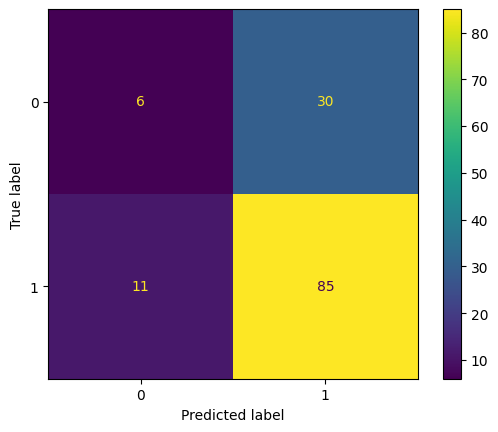

In [511]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier()
scores_48_original = []

cfm = np.array([[0,0],[0,0]])

X, y = get_X_y(data_48_original)
X = np.nan_to_num(X)

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    scores_48_original.append(accuracy_score(y[test], y_pred))
    cfm = cfm + confusion_matrix(y[test], y_pred)

print(np.mean(scores_48_original))

disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=clf.classes_)
disp.plot()
plt.show()

0.650997150997151


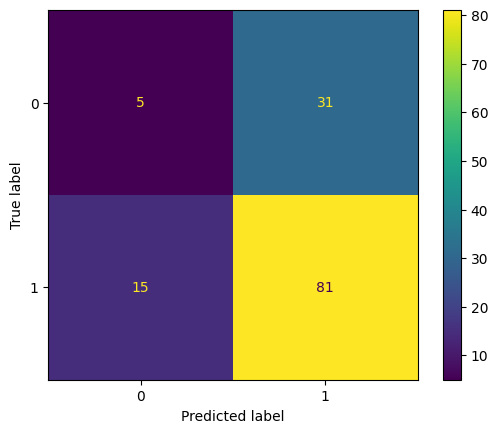

In [512]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier()
scores_24 = []

cfm = np.array([[0,0],[0,0]])

X, y = get_X_y(data_24)
X = np.nan_to_num(X)

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    scores_24.append(accuracy_score(y[test], y_pred))
    cfm = cfm + confusion_matrix(y[test], y_pred)

print(np.mean(scores_24))

disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=clf.classes_)
disp.plot()
plt.show()

0.6065527065527065


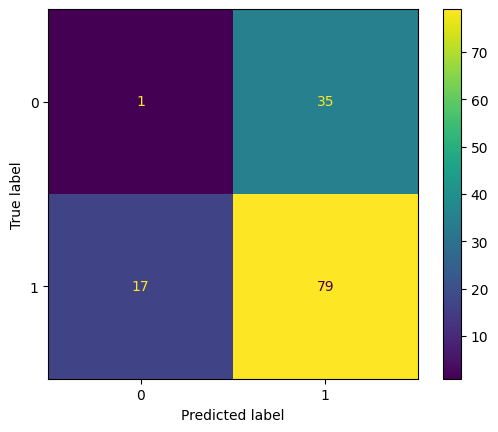

In [514]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier()
scores_48 = []

cfm = np.array([[0,0],[0,0]])

X, y = get_X_y(data_48)
X = np.nan_to_num(X)

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    scores_48.append(accuracy_score(y[test], y_pred))
    cfm = cfm + confusion_matrix(y[test], y_pred)

print(np.mean(scores_48))

disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=clf.classes_)
disp.plot()
plt.show()

Here the positive label is the short stay, while the negative label is the long stay. We can see that the original OASIS score in a 48h window works better with a 69.0% mean accuracy, compared to the modified version with 65.1% accuracy for 24h window, and 60.7% accuracy for 48h window. For the confusion matrices, we see that all three of them tend toi classify the stays as short more often.

The difference in accuracies could be due to the NaNs acting as zeroes gives more information on the less severe cases, so the classifiers has a better grasp on the LOS for those OASIS scores.

## Exercise 2:

1. Compute:
    - the number of different patients in the dataset: **100**
    - the number of different hospital admissions in the dataset: **129**
    - the number of different icu stays in the dataset: **136**
2. Show with an example that we can have a patient with more than one icustay: **The subject with ID 40304 has two ICU stays.**
3. Revise the number of ICU admissions registered by the two different systems: Metavision and Carevue. **There's 59 admissions registered with Carevue and 77 with Metavision**
4. Compute the number of NaN OASIS values for your different implementations. **There's only NaN values for the original OASIS implementation, exactly 101 NaNs**
5. Explain the difference between 'intime' from ICUSTAYS table and 'admittime' from ADMISSIONS table. **Admit time refers to the time when the patient arrives to the hospital, and the in time to the moment they enter the ICU stay**


In [525]:
df = pd.read_csv(path+"PATIENTS.csv")
print("There's", np.unique(df["subject_id"].values).shape[0], "patients in the dataset.")
df = pd.read_csv(path+"ADMISSIONS.csv")
print("There's", np.unique(df["hadm_id"].values).shape[0], "admissions in the dataset.")
df = pd.read_csv(path+"ICUSTAYS.csv")
print("There's", np.unique(df["icustay_id"].values).shape[0], "ICU stays in the dataset.")

There's 100 patients in the dataset.
There's 129 admissions in the dataset.
There's 136 admissions in the dataset.


In [547]:
df_1 = pd.read_csv(path+"PATIENTS.csv")
df_2 = pd.read_csv(path+"ADMISSIONS.csv")
df_3 = pd.read_csv(path+"ICUSTAYS.csv")
df_merged = df_2.merge(df_3, on=["subject_id", "hadm_id"], how="outer")
df_merged = df_1.merge(df_merged, on="subject_id", how="outer")
df_1 = None
df_2 = None
df_3 = None
df_merged[df_merged["subject_id"] == 40304]

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id_x,hadm_id,...,row_id_y,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
66,30873,40304,M,2086-12-16 00:00:00,2165-01-17 00:00:00,2165-01-17 00:00:00,2165-01-17 00:00:00,1,39866,174997,...,41424,261743,metavision,MICU,MICU,50,50,2163-11-21 18:34:25,2163-11-22 22:06:43,1.1474
67,30873,40304,M,2086-12-16 00:00:00,2165-01-17 00:00:00,2165-01-17 00:00:00,2165-01-17 00:00:00,1,39866,174997,...,41425,234424,metavision,MICU,MICU,50,50,2163-11-24 16:52:26,2163-11-25 20:31:19,1.1520


In [552]:
print("There's", sum(df_merged["dbsource"] == "carevue"), "admissions registered with carevue")
print("There's", sum(df_merged["dbsource"] == "metavision"), "admissions registered with metavision")

There's 59 admissions registered with carevue
There's 77 admissions registered with metavision


## Exercise 3:

Try to improve the prediction of the length of stay (LOS) of the ICU patients using all available variables (instead of the Oasis score) in the classification model learning a multidimensional decision boundary.

In [558]:
def process_group(data):
    return (
        np.amax(data["prelos"]),
        np.amax(data["age"]),
        np.mean(data["GCS_total"]),
        np.mean(data["hrate"]),
        np.mean(data["MAP"]),
        np.mean(data["resp_rate"]),
        np.mean(data["temp_c"]),
        np.mean(data["urine"]),
        0 if np.unique(data["ventilated"].values)[0] == 'n' else 1,
        0 if np.unique(data["admission_type"].values)[0] == 'elective' else (1 if np.unique(data["admission_type"].values)[0] == 'urgent' else 2),
        np.amax(data["los_oh"])
    )
    #return compute_oasis(data[["prelos","age","GCS_total","hrate","MAP","resp_rate","temp_c","urine","ventilated","admission_type"]]), np.amax(data["los_oh"])

data_last = df_final_24.groupby(by=["subject_id","hadm_id","icustay_id"]).apply(process_group)

In [575]:
X = []
y = []

for r in data_last.values:
    X.append(np.array(r[:-1]))
    y.append(r[-1])

X = np.array(X)
X = np.nan_to_num(X)
y = np.array(y)

0.7655270655270655


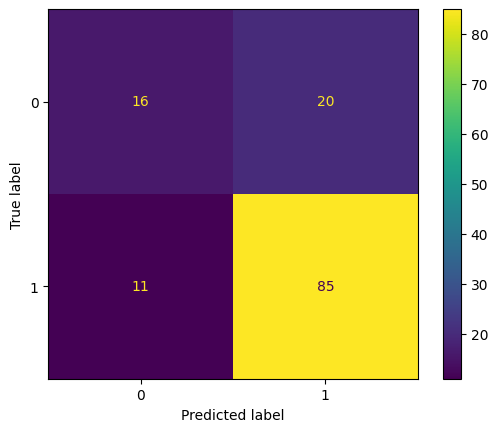

In [578]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
clf = RandomForestClassifier()
scores_last = []

cfm = np.array([[0,0],[0,0]])

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X[train], y[train])
    y_pred = clf.predict(X[test])
    scores_last.append(accuracy_score(y[test], y_pred))
    cfm = cfm + confusion_matrix(y[test], y_pred)

print(np.mean(scores_last))

disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=clf.classes_)
disp.plot()
plt.show()

To improve the score compared to the OASIS version, I used the mean of each of the measurements used in the OASIS score in a 24h window, so we end up with 10 different features for the classifier:
- 'prelos' => Pre-ICU length of stay, hours
- 'age' => Age of patient, years
- 'GCS_total' => Mean Glasgow Coma Scale for patient
- 'hrate' => Mean of all heart rate measurements
- 'MAP' => Mean of all mean arterial blood pressure measurements
- 'resp_rate' => Mean of all respiratory rate measurements
- 'temp_c' => Mean of all temperature measurements, C
- 'urine' => Mean of urine output over 24 h
- 'ventilated' => Is patient ventilated? (0,1)
- 'admission_type' => Type of admission (elective: 0, urgent: 1, emergency: 1) 

Here it scored 76.6% mean accuracy, which is an improvement from the previous methods. We also see that its more balanced when predicting the negative class (more specificity).